# RL and Advanced DL: Домашнее задание 1

### Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
<ul>
    <li> численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
    <li> туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
    <li> игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
    <li> игрок может совершать одно из двух действий:
    <ol>
        <li> <b>hit</b>  — взять ещё одну карту;
        <li> <b>stand</b> — не брать больше карт;
    </ol>
    <li> если сумма очков у игрока на руках больше 21, он проигрывает (bust);
    <li> если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
    <li> после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
    <li> в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
</ul>
Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
<ol>
    <li> Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
    <li> Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
    <li> Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.
</ol>


#### P.1: Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [ ]:
!pip install gym

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import itertools
from itertools import product
import random
from collections import defaultdict
from tqdm import tqdm
from blackjack import BlackjackEnv
from functools import partialmethod

In [2]:
env = BlackjackEnv(natural=True)

In [3]:
A = (0, 1)
S = list(product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}
pi_dummy = [int(state[0] not in {19, 20, 21}) for state, idx in s2idx.items()]


def play_game(env, pi):
    observation = env.reset()[0]
    terminated = False
    G = 0
    while not terminated:
        action = pi[s2idx[observation]]
        observation, reward, terminated, _, _ = env.step(action)
        G += reward
    return G


def evaluate_pi(env, pi=pi_dummy, n=100_000):
    rewards = []
    for _ in (range(n)):
        reward = play_game(env, pi)
        rewards.append(reward)
    return np.mean(rewards)

In [4]:
num_experiments = 100_000
reward_mean = evaluate_pi(env, n=num_experiments)
print(f'Evaluate basic strategy "19-20-21": {reward_mean:.5f} on num_of_tests: {num_experiments}')

Evaluate basic strategy "19-20-21": -0.18007 on num_of_tests: 100000


Оценка показывает проигрыш данной простой стратегии, понятен бейзлайн

#### P.2: Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [5]:
def get_pi_by_Q(Q):
    return np.argmax(Q, axis=1)

def episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    s = s2idx[env.reset()[0]]
    terminated = False
    get_actions_from_env = hasattr(env, 'get_actions')
        
    while not terminated:
        pi = get_pi_by_Q(Q)
        a = pi[s] if random.random() < (1 - epsilon) else random.choice(env.get_actions() if get_actions_from_env else A)
        observation, reward, terminated, _, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (reward + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

def q_learning(env, A, Q, episodes=100_000, alpha=0.009, epsilon=0.85, gamma=1):
    for _ in tqdm(range(episodes)):
        Q = episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        
    return Q
        

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def plot_q_learinig(env, A, alpha, epsilon, episodes=1000, n_experiments=50, n_eval=100):

    Q_arr = [np.zeros((len(S), len(A)))] * n_experiments
    pi_arr = [get_pi_by_Q(Q) for Q in Q_arr]
    results = []
    episode_results = []
    episode_nums = []

    for eps in range(episodes):
        experiments_result = []
        for i in range(n_experiments):
            Q_arr[i] = episode(env, Q_arr[i], A, alpha=alpha, epsilon=epsilon)
            pi_arr[i] = get_pi_by_Q(Q_arr[i])
            experiments_result.append(evaluate_pi(env, pi_arr[i], n=n_eval))

        episode_results.append(np.mean(experiments_result))
        episode_nums.append(eps)

    plt.figure(figsize=(16, 8))
    plt.plot(episode_nums, episode_results, linewidth=1)
    plt.xlabel('train_episodes')
    plt.ylabel('reward')
    plt.show()

In [6]:
Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=100_000, alpha=0.02, epsilon=0.1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=num_experiments)
print(f'Q-training evaluation< reward: {reward_mean:.5f}')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 8902.34it/s]


Q-training evaluation< reward: -0.13188


Реализован алгоритм Q-обучения, далее рассмотрим, как выбор гипер-параметров влияет на результат обучения

#### P.3: Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [7]:
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
for epsilon in np.linspace(0.05, 1, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=epsilon)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.06371
epsilon=0.10000, reward=-0.05593
epsilon=0.15000, reward=-0.05915
epsilon=0.20000, reward=-0.05824
epsilon=0.25000, reward=-0.05852
epsilon=0.30000, reward=-0.05246
epsilon=0.35000, reward=-0.05252
epsilon=0.40000, reward=-0.04989
epsilon=0.45000, reward=-0.04932
epsilon=0.50000, reward=-0.04912
epsilon=0.55000, reward=-0.04099
epsilon=0.60000, reward=-0.04533
epsilon=0.65000, reward=-0.03960
epsilon=0.70000, reward=-0.03718
epsilon=0.75000, reward=-0.04064
epsilon=0.80000, reward=-0.03551
epsilon=0.85000, reward=-0.03230
epsilon=0.90000, reward=-0.03456
epsilon=0.95000, reward=-0.03051
epsilon=1.00000, reward=-0.03329


In [8]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]: #np.linspace(0.001, 0.02, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = q_learning(env, A, Q, episodes=100_000, alpha=alpha, epsilon=0.95)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')
    
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

alpha=0.00001, reward=-0.03255
alpha=0.00002, reward=-0.03422
alpha=0.00005, reward=-0.03163
alpha=0.00010, reward=-0.03356
alpha=0.00020, reward=-0.03041
alpha=0.00050, reward=-0.03657
alpha=0.00100, reward=-0.03450
alpha=0.00200, reward=-0.05578
alpha=0.00500, reward=-0.09073
alpha=0.01000, reward=-0.13895
alpha=0.02000, reward=-0.13721
alpha=0.05000, reward=-0.11768


Зафиксируем значения: epsilon = 0.95, alpha = 0.00005

In [9]:
Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=num_experiments)
print(f'Q-training evaluation on fitted params, reward: {reward_mean:.5f}')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9551.34it/s]


Q-training evaluation on fitted params, reward: -0.02986


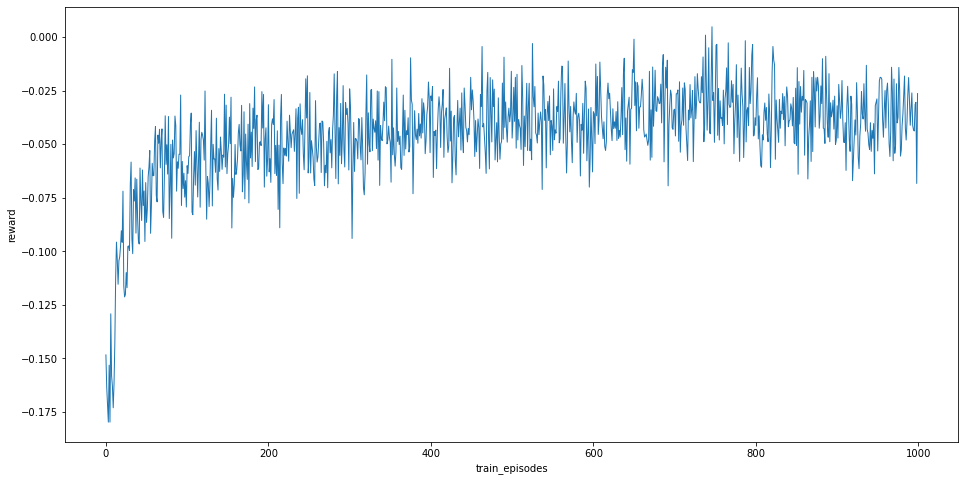

In [10]:
plot_q_learinig(env, A, alpha=0.00005, epsilon=0.95)

### Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
<ul>
    <li> <b>double</b> — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
</ul>
<ol start="4">
    <li> Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
    <li> Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.
</ol>


#### P.4: Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [11]:
from blackjack import BlackjackDoubleEnv

#### P.5: Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [12]:
env = BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)

S = list(product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [13]:
Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)

print(f'Q-training evaluation on method with double, reward: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 11576.41it/s]


Q-training evaluation on method with double, reward: -0.02243


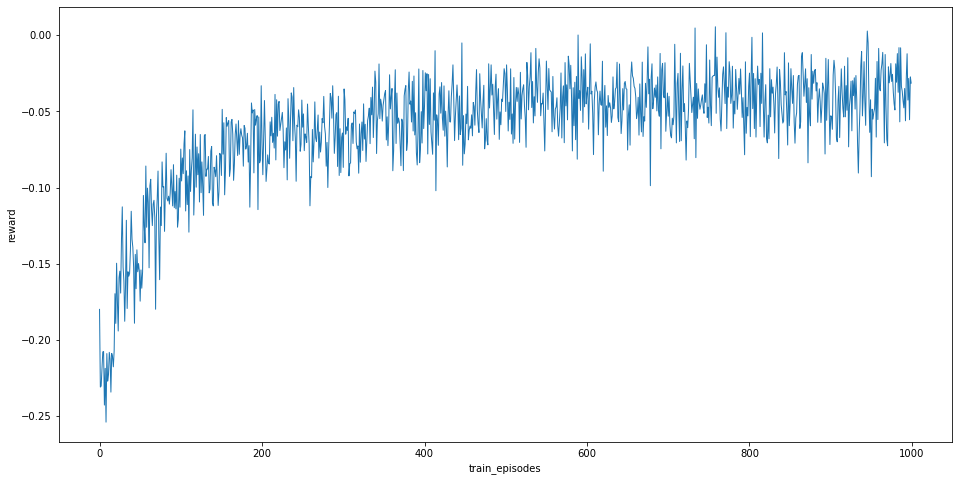

In [14]:
plot_q_learinig(env, A, alpha=0.00005, epsilon=0.95)

Удвоение ещё улучшило скор, но мы по-прежнему проигрываем казино

### Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

<ol start="6">
    <li>Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
    <li>Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.
</ol>

#### P.6: Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [15]:
from blackjack import BlackjackDoubleCntEnv

#### P.7: Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [16]:
env = BlackjackDoubleCntEnv(natural=True)
A = (0, 1, 2)

S = list(product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [17]:
def play_game(env, pi):
    observation = env.reset()
    terminated = False
    G = 0
    while not terminated:
        action = pi[s2idx[observation]]
        observation, reward, terminated, _ = env.step(action)
        G += reward
    return G

def episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    s = s2idx[env.reset()]
    terminated = False
    get_actions_from_env = hasattr(env, 'get_actions')
        
    while not terminated:
        pi = get_pi_by_Q(Q)
        a = pi[s] if random.random() < (1 - epsilon) else random.choice(env.get_actions() if get_actions_from_env else A)
        observation, reward, terminated, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (reward + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

In [19]:
Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=300_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=300_000)

print(f'Estimation of double & count rules Q-training: {reward_mean:.5f}')

100%|████████████████████████████████████████████████████████████████████████| 300000/300000 [01:35<00:00, 3132.79it/s]


Estimation of double & count rules Q-training: 0.01313


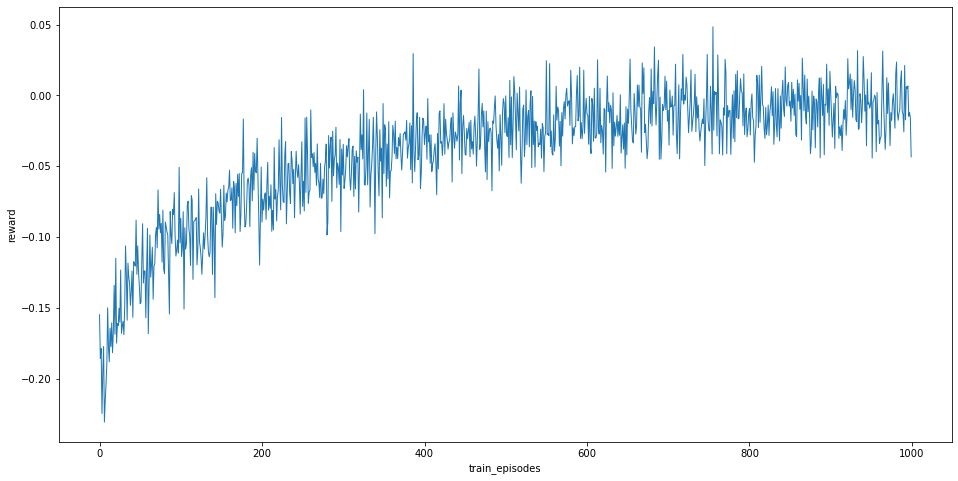

In [20]:
plot_q_learinig(env, A, alpha=0.00005, epsilon=1)

Тут можно увидеть, что получается незначительно обыгрывать казино и выходить в плюс

### Часть четвёртая, опциональная

Ну и напоследок ещё парочка опциональных заданий за дополнительные баллы.
<ol start=8>
    <li> Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. найти или обучить вероятности переходов между состояниями.
    <li> Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!
</ol>


. . . .